In [1]:
from pathlib import Path
import sys
# Agregar el path del directorio "code"
code_path = Path("../code").resolve()
if str(code_path) not in sys.path:
    sys.path.insert(0, str(code_path))


In [2]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
#from utils import get_channel
#from CustomTransformers import TimeSeriesFreqRegularization
#from utils import rolling_forecast
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from itertools import product
from TimeSeriesUtils import rolling_forecast

def plot_serie(df):
    plt.figure(figsize=(12, 6))
    for c in df.columns:
        plt.plot(df.index, df[c], label=c)
    plt.title('ETH-USD Open Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

In [3]:
df = pd.read_csv("../datasets/ETH-USD_Open.csv", parse_dates=True, index_col="Datetime")
#method {‘backfill’/’bfill’, ‘pad’/’ffill’}, default None
#df = df.asfreq("T")
df["Price"] = df["Open"]
df.drop(columns=["Open"], inplace=True)
df.sort_index(inplace=True)


¿Tenemos nulos?

In [4]:
#Si, columnas hay una sola, pero lo dejamos genérico para otros casos
for c in df.columns:
    print(f"{c}: {df[c].isnull().sum()} nulos")

Price: 0 nulos


¿Hay duplicados?

In [5]:
df.index.duplicated().any() #df[df.index.duplicated(keep=False)]

False

¿La periodicidad es estable?

In [6]:
df_time_diffs = df.index.to_series().diff().dt.total_seconds()  
print(df_time_diffs.value_counts())

Datetime
60.0     1054
120.0     157
180.0       1
Name: count, dtype: int64


No, no lo es...lo tenemos que solucionar. Hay muchas formas, usemos asfreq, que deje nulos y luego interpolamos. Ver que asfreq podria usar una estrategia ffill que suele recomendarse.

In [7]:
ndf = df.copy() 
ndf = ndf.asfreq("60s", method=None)
ndf["Price_ffill"] = df.asfreq("60s", method="ffill")
ndf["Price_none"] = df.asfreq("60s", method=None)
ndf["Price_interpolated"] = ndf["Price_none"].interpolate(method='linear')


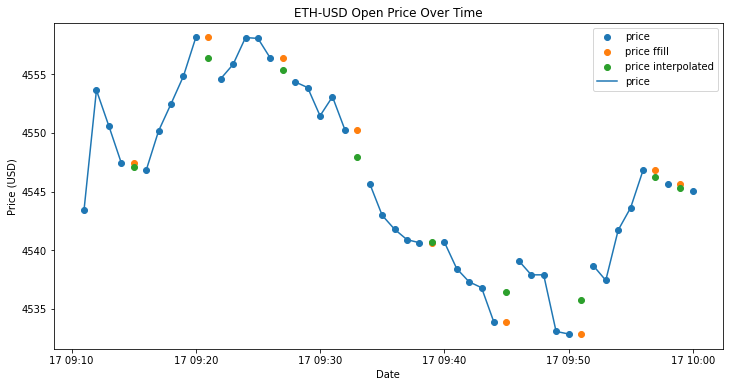

In [8]:
sndf = ndf.iloc[550:600]
plt.figure(figsize=(12, 6))
plt.scatter(sndf.index, sndf["Price"], label="price")
plt.scatter(sndf.loc[sndf["Price_none"].isnull(), "Price_ffill"].index, sndf.loc[sndf["Price_none"].isnull(), "Price_ffill"] , label="price ffill")
plt.scatter(sndf.loc[sndf["Price_none"].isnull(), "Price_interpolated"].index, sndf.loc[sndf["Price_none"].isnull(), "Price_interpolated"] , label="price interpolated")

plt.plot(sndf.index, sndf["Price_none"], label="price")
plt.title('ETH-USD Open Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


Me quedo con Price_ffill

In [9]:
df = ndf[["Price_ffill"]].copy()
df["Price"] = df["Price_ffill"]
df.drop(columns=["Price_ffill"], inplace=True)

Ver valores ¿Es estacionaria?

In [10]:
ADF_result = adfuller(df["Price"])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.6497059672795582
p-value: 0.4571937760763092


No rechazamos la hipótesis nula de que la serie tiene una raíz unitaria y por tanto la serie no es estacionaria. Debemos obtener la diferencia de primer orden. 

In [11]:
df.loc[:,['values_diff']] = df["Price"].diff()
df_diff1 = df.copy()
#Eliminamos el nulo del inicio
df_diff1.dropna(inplace=True)

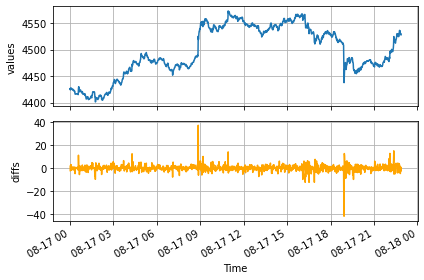

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df["Price"])
ax1.set_xlabel('Time')
ax1.set_ylabel('values')
#ax1.axvspan(450, 500, color='#808080', alpha=0.2)
ax1.grid()
ax2.plot(df['values_diff'], color='orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('diffs')
ax2.grid()
#ax2.axvspan(449, 498, color='#808080', alpha=0.2)


fig.autofmt_xdate()
plt.tight_layout()

plt.show()

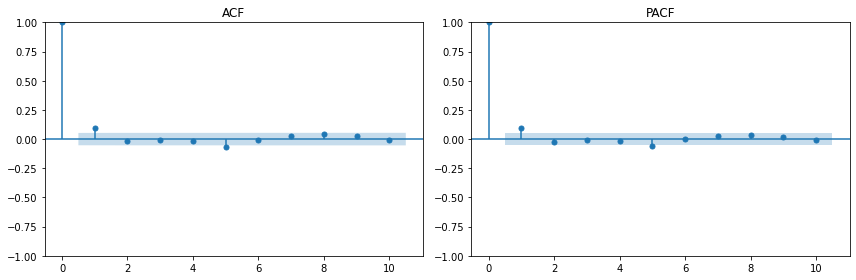

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ACF
plot_acf(df_diff1["values_diff"], ax=axes[0], lags=10, alpha=0.05)
axes[0].set_title("ACF")

# PACF
plot_pacf(df_diff1["values_diff"], ax=axes[1], lags=10, alpha=0.05, method="ywm")
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

Ambos se ven iguales, no hay correlaciones significativas, puede ser un AR(1) o un MA(1) muy débil, no hay dependencias.

Sigamos adelante (Somos difíciles de convencer)

¿Que tal búsqueda exhaustiva?

In [14]:
ps = range(0, 2, 1)    
qs = range(0, 2, 1)
#Producto cartesiano de los valores de p y q
# Esto genera todas las combinaciones posibles de p y q
order_list = list(product(ps, qs))

In [15]:
ldf = df_diff1.copy()
train_len = int(ldf.shape[0]*0.9)
test_len = ldf.shape[0] - train_len
train = ldf[:train_len]
test = ldf[train_len:]
results = []
for p, q in order_list:
    try:
        model = SARIMAX(train['values_diff'], order=(p, 0, q), simple_differencing=False)
        model_fit = model.fit(disp=False)
    except:
        print(f"Error with order ({p}, {q}), skipping...")
        continue
    aic = model_fit.aic
    results.append([(p, q), aic])

Parece que lo mejor es un q=1, media móvil de 1. Restaría analizar los residuos.

In [16]:
result_df = pd.DataFrame(results)
result_df.columns = ['(p,q)', 'AIC']
#Sort in ascending order, lower AIC is better
result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
result_df.loc[:5,:]

,"(p,q)",AIC
0,"(0, 1)",6146.306064
1,"(1, 0)",6147.089461
2,"(1, 1)",6148.030266
3,"(0, 0)",6159.848581


In [17]:
p, q = result_df.loc[0].values[0]
model = SARIMAX(train['values_diff'], order=(p,0,q), simple_differencing=False)
model_fit = model.fit(disp=False)
#print(model_fit.summary())

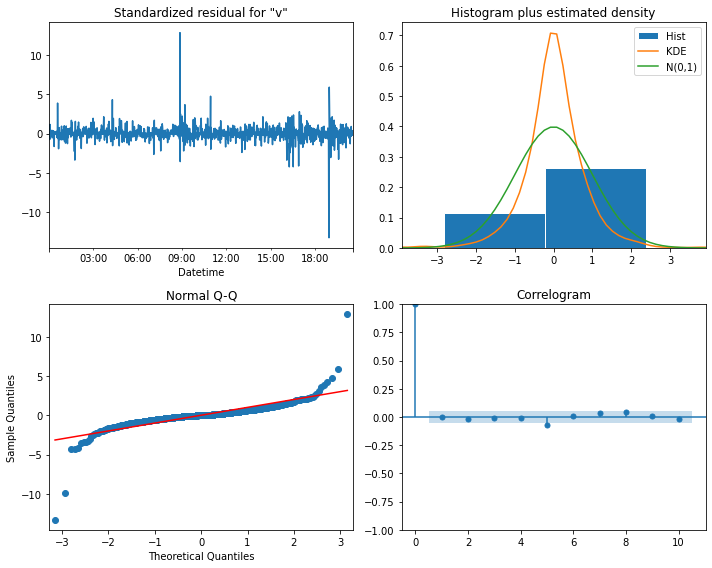

In [18]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

Tanto el QQ como el histograma muestran fallas en los residuos. La curva KDE no se superpone con el histograma

In [19]:
residuos = model_fit.resid
print(residuos.head())

Datetime
2025-08-17 00:02:00+00:00   -2.188477
2025-08-17 00:03:00+00:00    2.549337
2025-08-17 00:04:00+00:00   -2.171048
2025-08-17 00:05:00+00:00    3.381158
2025-08-17 00:06:00+00:00   -0.832355
Freq: 60S, dtype: float64


¿Le podemos ganar a alguna estrategia ingenua?

In [20]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1
print(f'TRAIN_LEN: {TRAIN_LEN}, HORIZON: {HORIZON}, WINDOW: {WINDOW}')

TRAIN_LEN: 1233, HORIZON: 138, WINDOW: 1


In [21]:
pred_mean       = rolling_forecast(ldf[['values_diff']], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(ldf[['values_diff']], TRAIN_LEN, HORIZON, WINDOW, 'last')
order = (0, 0, 1)
seasonal_order = (0, 0, 0, 0)
pred_ARMA       = rolling_forecast(ldf[['values_diff']], TRAIN_LEN, HORIZON, WINDOW, 'ARMA', order=order, seasonal_order=seasonal_order)

In [22]:
test.loc[:, ['pred_mean']]        = pred_mean
test.loc[:, ['pred_last_value']]  = pred_last_value
test.loc[:, ['pred_ARMA']]        = pred_ARMA

test.head()

,Price,values_diff,pred_mean,pred_last_value,pred_ARMA
Datetime,,,,,
2025-08-17 20:35:00+00:00,4479.191406,0.546875,0.042471,-0.393555,-0.058531
2025-08-17 20:36:00+00:00,4478.031250,-1.160156,0.042879,0.546875,0.069363
2025-08-17 20:37:00+00:00,4477.994141,-0.037109,0.041905,-1.160156,-0.140770
2025-08-17 20:38:00+00:00,4478.823242,0.829102,0.041841,-0.037109,0.011866
2025-08-17 20:39:00+00:00,4479.456055,0.632812,0.042478,0.829102,0.093576


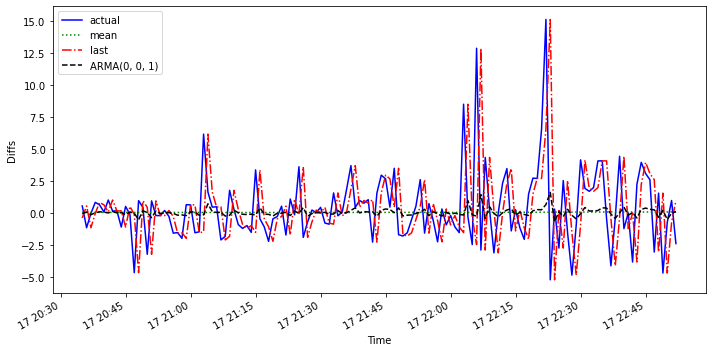

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(df['values'])
ax.plot(test['values_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label=f'ARMA{order}')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Diffs')
#ax.axvspan(947, 998, color='#808080', alpha=0.2)
#ax.set_xlim(920, 999)
#plt.xticks([936, 988],[2018, 2019])
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

¿Que modelo dio mejor?

<Figure size 576x360 with 0 Axes>

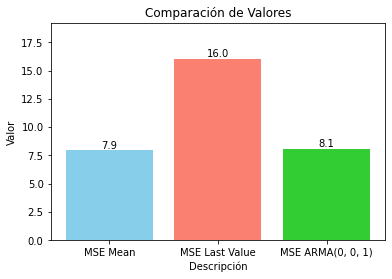

In [24]:
from sklearn.metrics import mean_squared_error
mse_mean    = mean_squared_error(test['values_diff'], test['pred_mean'])
mse_last    = mean_squared_error(test['values_diff'], test['pred_last_value'])
mse_MA      = mean_squared_error(test['values_diff'], test['pred_ARMA'])

df_comm = pd.DataFrame({
    'Descripción': ['MSE Mean', 'MSE Last Value', f'MSE ARMA{order}'],
    'Valor': [mse_mean, mse_last, mse_MA]
})

plt.figure(figsize=(8, 5))

fig, ax = plt.subplots()
bars = ax.bar(df_comm['Descripción'], df_comm['Valor'], color=["skyblue", "salmon", "limegreen"])
ax.bar_label(bars, fmt='%.1f')  # podés cambiar formato, ej. 1 decimal
plt.title('Comparación de Valores')
plt.xlabel('Descripción')
plt.ylabel('Valor')
plt.ylim(0, max(df_comm['Valor']) * 1.2)  # margen superior
plt.show()

No, ni siquiera eso, la media dia mejor resultado. 